# PCA-GAN (after optimization)
We use CNN-GAN, the PCA is applied to  data.
The generator model generates samples from latent space to the PCA-space, the discriminator model distinguishes real and fake samples in the PCA-space. The inverse PCA transformation is used after generation in order to represent samples from the PCA-space to the initial space.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import time
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler    
import random
import torch.autograd as autograd
import torch.nn.functional as F

import torch.autograd as autograd
import pickle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

random_seed = 0
torch.manual_seed(random_seed)
random.seed(random_seed)
DEVICE = torch.device('cpu')

In [3]:
params = pickle.load(open('best_parameters.pkl', 'rb'))
print(params)

{'epochs': 119, 'lr': 0.03453234251828275, 'optimizers': 3}


In [4]:
params_model = pickle.load(open('best_model_parameters.pkl', 'rb'))
print(params_model)

{'seq_len': 94, 'random_dim': 23}


In [5]:
params.update(params_model)

In [6]:
print(params)

{'epochs': 119, 'lr': 0.03453234251828275, 'optimizers': 3, 'seq_len': 94, 'random_dim': 23}


In [8]:
seq_len = params.get('seq_len')# dimensionality of the PCA-space
random_dim = params.get('random_dim')# the latent space dimensionality
lr = params.get('lr')# learning rate
epochs = params.get('epochs')
batch_size = 128

## 1. Preprocessing

In [6]:
pulses = pickle.load(open('/Users/nzaretski/Desktop/gerda/CNN_GAN_Ge/data/raw/data.pkl','rb'))
pulses = pulses.astype(float)

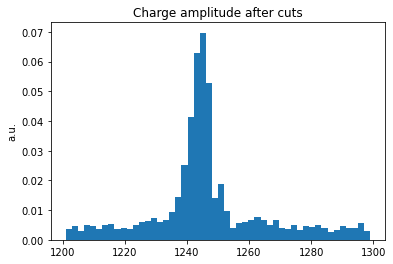

In [7]:
plt.hist(np.max(pulses, axis = 1) - np.min(pulses, axis = 1), bins = 50, density=True)
plt.title('Charge amplitude after cuts')
plt.ylabel('a.u.')
plt.show()

In [8]:
print(pulses.shape)

(2619, 5000)


Text(0, 0.5, 'a.u.')

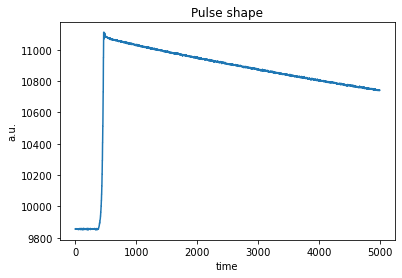

In [9]:
plt.plot(pulses[1])
plt.title('Pulse shape')
plt.xlabel('time')
plt.ylabel('a.u.')

In [10]:
scaler = StandardScaler()
pulses = scaler.fit_transform(pulses) 

pulses = PCA(n_components=params['seq_len'])
pulses = pca.fit_transform(pulses)

In [11]:
pickle.dump(scaler, open('scaler_pca.pkl','wb'))
pickle.dump(pca, open('pca_pca.pkl','wb'))

In [12]:
train_data_length = pulses.shape[0]
train_data = torch.zeros((train_data_length, pulses.shape[1]))
train_data = torch.tensor(pulses, dtype=torch.float)
train_labels = torch.zeros(train_data_length, 1)

train_set = [
    (train_data[i], train_labels[i]) for i in range(train_data_length)
]

In [14]:
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True, drop_last=True
)

## 2. Models

In [16]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.seq_len = seq_len
        self.model = nn.Sequential(            
            nn.Conv1d(self.seq_len, self.seq_len // 2, 1,  bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 2, self.seq_len // 4, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 4),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 4, self.seq_len // 8, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv1d(self.seq_len // 8, self.seq_len // 16, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 16),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv1d(self.seq_len // 16, 1, 1, bias=False),
        )
    def forward(self, x):
        x = x.unsqueeze(-1)
        output = self.model(x)
        return torch.sigmoid(output.squeeze(-1))

In [17]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.seq_len = seq_len
        self.random_dim = random_dim
        self.model = nn.Sequential(
            nn.ConvTranspose1d(self.random_dim, self.seq_len // 4, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 4),
            nn.ReLU(True),

            nn.ConvTranspose1d(self.seq_len // 4, self.seq_len // 2, 1, bias=False),
            nn.BatchNorm1d(self.seq_len // 2),
            nn.ReLU(True),
            
            nn.ConvTranspose1d(self.seq_len // 2, self.seq_len, 1, bias=False)
      )
    def forward(self, z):
        z = z.unsqueeze(-1)
        output = self.model(z)
        return output.squeeze(-1)

#  Minimax

In [18]:
netD = Discriminator().to(DEVICE)
netG = Generator().to(DEVICE)
criterion = nn.BCELoss()

optimizerD = torch.optim.SGD(netD.parameters(), lr=lr)
optimizerG = torch.optim.SGD(netG.parameters(), lr=lr)

In [20]:
G_losses = []
D_losses = []

for epoch in range(epochs):
    for i, (x, y) in enumerate(train_loader):
        # real samples
        x = x.to(DEVICE)
        real_samples_labels = torch.ones((batch_size, 1))
        # real samples' labels = 1
        real_samples_labels = real_samples_labels.to(DEVICE)
        
        # generated (fake) samples
        latent_space_samples = torch.randn((batch_size, random_dim))
        latent_space_samples = latent_space_samples.to(DEVICE)
        generated_samples = netG(latent_space_samples)
        # fake samples' labels = 0
        generated_samples_labels = torch.zeros((batch_size, 1))
        generated_samples_labels = generated_samples_labels.to(DEVICE)
        
        all_samples = torch.cat((x, generated_samples))
        all_samples_labels = torch.cat((real_samples_labels, generated_samples_labels))
        
        ## training the discriminator
        netD.zero_grad()
        output_discriminator = netD(all_samples)
        
        errD = criterion(output_discriminator, all_samples_labels)
        errD.backward()
        optimizerD.step()
        
        ## training the generator
        latent_space_samples = torch.randn(batch_size, random_dim)
        latent_space_samples = latent_space_samples.to(DEVICE)
        netG.zero_grad()
        generated_samples = netG(latent_space_samples)
        outputDG = netD(generated_samples)
        errG = criterion(outputDG, real_samples_labels)
        errG.backward()
        optimizerG.step()
        
        G_losses.append(errG.item()) 
        D_losses.append(errD.item())
    
        
    if (epoch % 5 == 0):
            print(f"Epoch{epoch} Loss D.: {errD}" "||" 
              f"Loss G.: {errG}")

Epoch0 Loss D.: 0.471468061208725||Loss G.: 0.7049261331558228
Epoch5 Loss D.: 0.11079531908035278||Loss G.: 0.6920789480209351
Epoch10 Loss D.: 0.04674987122416496||Loss G.: 0.6811950206756592
Epoch15 Loss D.: 0.028325162827968597||Loss G.: 0.6433761715888977
Epoch20 Loss D.: 0.018232394009828568||Loss G.: 0.5924869775772095
Epoch25 Loss D.: 0.013259620405733585||Loss G.: 0.5495758056640625
Epoch30 Loss D.: 0.010860968381166458||Loss G.: 0.5089505910873413
Epoch35 Loss D.: 0.008116895332932472||Loss G.: 0.49127525091171265
Epoch40 Loss D.: 0.006592164281755686||Loss G.: 0.4963934123516083
Epoch45 Loss D.: 0.005776457488536835||Loss G.: 0.44838833808898926
Epoch50 Loss D.: 0.005487382877618074||Loss G.: 0.5044540166854858
Epoch55 Loss D.: 0.004379109013825655||Loss G.: 0.4396999478340149
Epoch60 Loss D.: 0.003826151369139552||Loss G.: 0.4324480891227722
Epoch65 Loss D.: 0.003534060437232256||Loss G.: 0.4384332597255707
Epoch70 Loss D.: 0.0033587797079235315||Loss G.: 0.4364065527915954

In [21]:
torch.save(netG.state_dict(), 'generator_pca.pth')

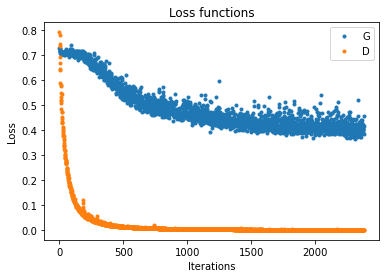

In [22]:
fig = plt.figure()
plt.plot(G_losses, '.', label='G')
plt.plot(D_losses, '.',  label='D')
plt.title('Loss functions')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
fig.savefig('losses.png')

## 2. First check

In [23]:
netG = Generator() 
netG.load_state_dict(torch.load("generator_pca.pth"))

pca = pickle.load(open('pca_pca.pkl','rb'))
scaler = pickle.load(open('scaler_pca.pkl','rb'))

In [24]:
x = torch.randn(10, random_dim)

In [25]:
gen = netG(x).detach()
gen = pca.inverse_transform(gen) # back to 5000 points
gen = scaler.inverse_transform(gen)

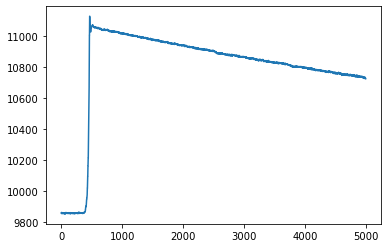

In [26]:
plt.plot(gen[0])